[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bachhvu/Amazon-NLP/blob/main/Model%20Development.ipynb)



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Preprocessed Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [71]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Electronics_processed.csv', index_col=0)
df

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,review_text,review_time
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",5.0,1370131200,got ta gps got gps husband otr road trucker im...,2013-06-02
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]",1.0,1290643200,disappointed professional otr truck driver bou...,2010-11-25
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]",3.0,1283990400,impression well say unit truck four day prior ...,2010-09-09
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]",2.0,1290556800,great grafics poor gps going write long review...,2010-11-24
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",1.0,1317254400,major issue excuse support mine year got try r...,2011-09-29
...,...,...,...,...,...,...,...,...
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,"Candy Cane ""Is it just me?""","[1, 1]",5.0,1405555200,boom pop pow deliver burned listening hour sin...,2014-07-17
1689184,A1G650TTTHEAL5,B00LGQ6HL8,"Charles Spanky ""Zumina Reviews""","[0, 0]",5.0,1405382400,thin light without compromising sound quality ...,2014-07-15
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,Comdet,"[0, 0]",5.0,1405555200,form factor durability better sound quality im...,2014-07-17
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,J. Chambers,"[0, 0]",5.0,1405641600,superb audio quality comfortable set earphone ...,2014-07-18


In [72]:
df = df.sample(n = 10000, random_state=42)

# Extra Data Wrangling

In [6]:
##########################################
## Classify ratings as good
##########################################

good_rate = len(df[df['overall'] >= 3])
bad_rate = len(df[df['overall'] < 3])

# Printing rates and their total numbers
print ('Good ratings : {} reviews for products'.format(good_rate))
print ('Bad ratings : {} reviews for products'.format(bad_rate))

Good ratings : 8900 reviews for products
Bad ratings : 1100 reviews for products


In [7]:
df['rating_class'] = df['overall'].apply(lambda x: 0 if x < 3 else 1)
df.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,review_text,review_time,rating_class
1360852,AVCMFK6FBAXO3,B0083C8B30,"Edward Jasudowich ""Edsgolfin""","[1, 1]",5.0,1358985600,switch pioneer simplifed life improved home th...,2013-01-24,1
1672835,A3M64BWMQO6JAL,B00GTGETFG,Amazon Customer,"[0, 0]",5.0,1400630400,power demand lot power needed use charge three...,2014-05-21,1
1626762,A1S9FUIB8R4ZO7,B00DTPYRKC,L T.,"[0, 0]",5.0,1387843200,replacement hdd macbook pro bought ssd replace...,2013-12-24,1
62247,A1V7MCPGTUJ6YY,B00009EHJV,"Bud ""Mac user""","[0, 0]",5.0,1303430400,work great mac vmware fusion installed mac usi...,2011-04-22,1
568677,A3Q2XTSWJBGB89,B0027JRX52,Marcos,"[0, 0]",4.0,1347667200,good solution carry necessary gear occasion wa...,2012-09-15,1


In [73]:
df['review_time'] = pd.to_datetime(df['review_time'], format='%Y/%m/%d')

# Exploratory Data Analysis

Summary Statistics

In [ ]:
# Statistics of non-numeric variables

# Number of unique customers
print('\nNumber of unique customers : {}'.format(len(df['reviewerID'].unique())))
      
# Number of unique products
print('\nNumber of unique products : {}'.format(len(df['asin'].unique())))
      
# Review number per unique customer
print('\nReview per customer: {}'.format((len(df)/len(df['reviewerID'].unique()))))      

# Review number per unique product 
print('\nReview per product: {}'.format((len(df)/len(df['asin'].unique()))))


Number of unique customers : 192403

Number of unique products : 63001

Review per customer: 8.779416121370248

Review per product: 26.81205060237139


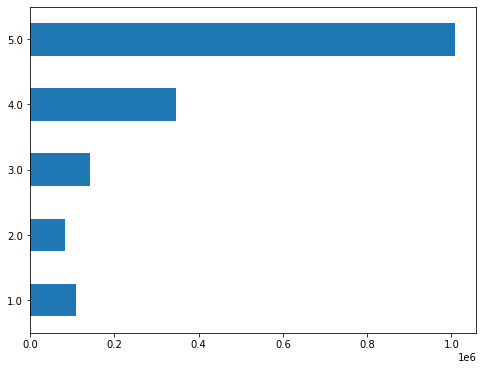

In [ ]:
plt.figure(figsize=(8,6))
df['overall'].value_counts().sort_index().plot(kind="barh")

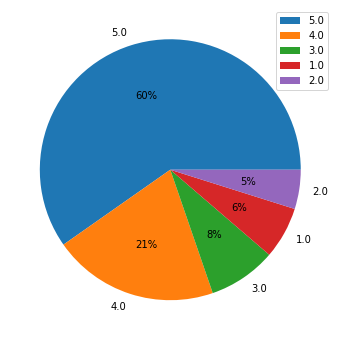

In [ ]:
plt.figure(figsize=(8,6))
plt.pie(df['overall'].value_counts(), labels = df['overall'].value_counts().index, autopct='%1.0f%%')
plt.legend()

Plot number of review per day

In [125]:
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

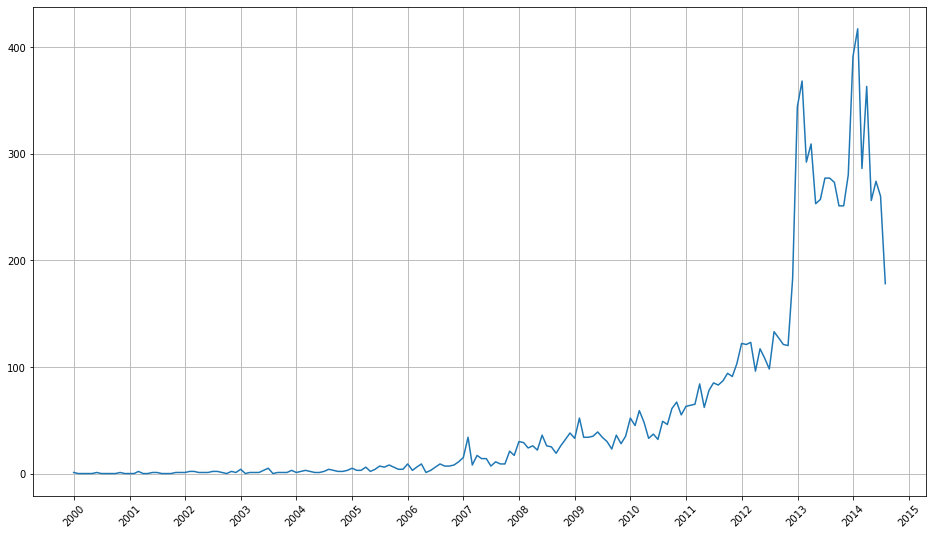

In [158]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(df.groupby(pd.Grouper(key='review_time', freq='M')).count().sort_index().index, df.groupby(pd.Grouper(key='review_time', freq='M')).count()['review_text'])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.grid()

Plot number of unique customer leaving review per day

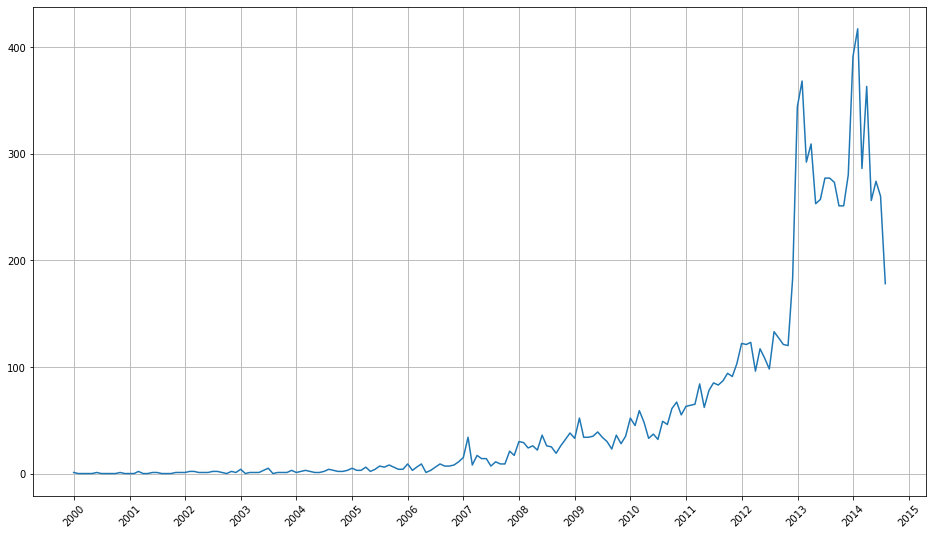

In [164]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(df.groupby(pd.Grouper(key='review_time', freq='M')).count().sort_index().index, df.groupby(pd.Grouper(key='review_time', freq='M')).count()['reviewerID'])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.grid()

Plot number of product reviewed per day

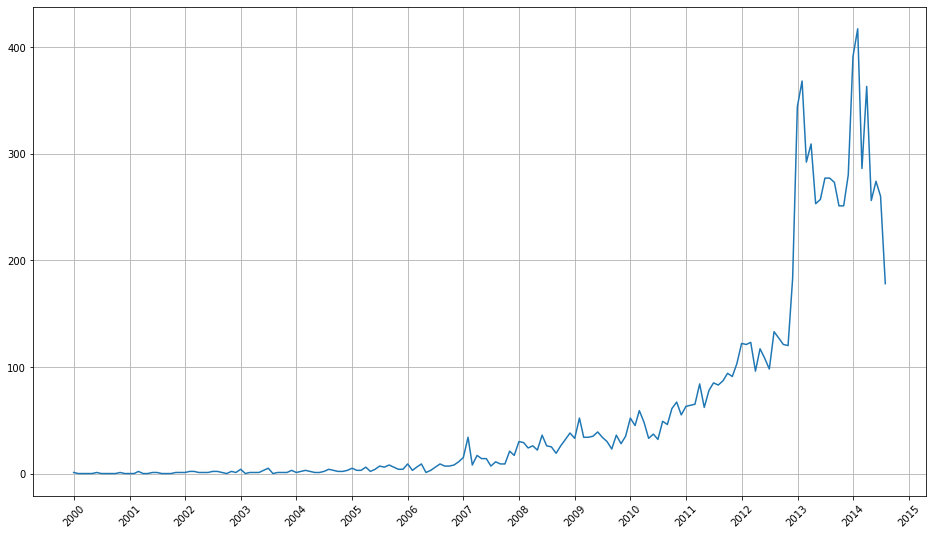

In [163]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(df.groupby(pd.Grouper(key='review_time', freq='M')).count().sort_index().index, df.groupby(pd.Grouper(key='review_time', freq='M')).count()['asin'])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.grid()

In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(18, 6))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

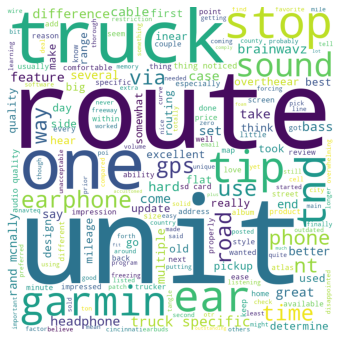

In [ ]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width= 800, height = 800, random_state=1, background_color='white', stopwords = STOPWORDS).generate(str(df['review_text'].values))
# Plot
plot_cloud(wordcloud)

# Model Development

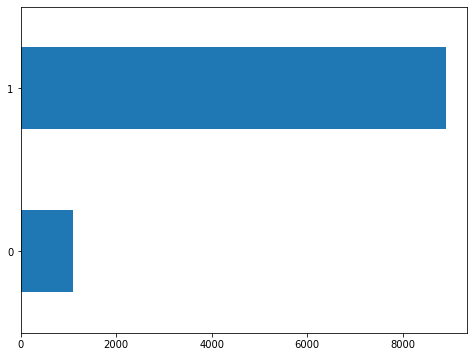

In [ ]:
plt.figure(figsize=(8,6))
df['rating_class'].value_counts().sort_index().plot(kind="barh")

In [ ]:
df = df.dropna(subset=['review_text'])

In [ ]:
df['review_text'].isnull().values.any()

False

In [ ]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer("english", ngram_range=(1,2), min_df=5, max_df=0.7, use_idf=True)
# fit the vectorizer using the text data
tfid = tfid_vectorizer.fit(df['review_text'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

tfid_matrix = tfid_vectorizer.transform(df['review_text']).todense()
feature_names = tfid_vectorizer.get_feature_names()

# store the tf-idf array into pandas dataframe
df2 = pd.DataFrame(tfid_matrix, columns=feature_names)
df2['rating_class'] = df['rating_class']
df2

,aa,aa aaa,aa battery,aaa,aaa battery,aac,ab,aberration,ability,ability play,ability use,able,able access,able add,able adjust,able charge,able connect,able control,able easily,able figure,able find,able fit,able fully,able get,able hear,able hook,able keep,able listen,able mount,able move,able pick,able play,able plug,able pull,able put,able reach,able remove,able see,able set,able shoot,...,yet try,yet use,yield,yongnuo,young,younger,youre,youtube,youtube video,yr,yr old,zagg,zalman,zeikos,zeiss,zen,zen vision,zero,zero issue,zip,zip tie,zipped,zipper,zippered,zippered pocket,zone,zoom,zoom camera,zoom digital,zoom feature,zoom lens,zoom picture,zoom range,zoom ring,zoom setting,zoom would,zoomed,zooming,zune,rating_class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.

Split the data into train and test subset

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df2[feature_names], df2['rating_class'], test_size=0.25, random_state=0)

## Support Vector Machine

In [ ]:
classifier = LinearSVC(random_state=0)

In [ ]:
alpha_list = np.linspace(0.1,1,10)
alpha_list = np.around(alpha_list, decimals=4)
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
params = {'C': alpha_list}

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



In [ ]:
import time
start_time = time.time()
grid_no_up = GridSearchCV(classifier, param_grid=params, cv=kf, n_jobs=-1, verbose=1, scoring='f1_macro').fit(X_train, y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


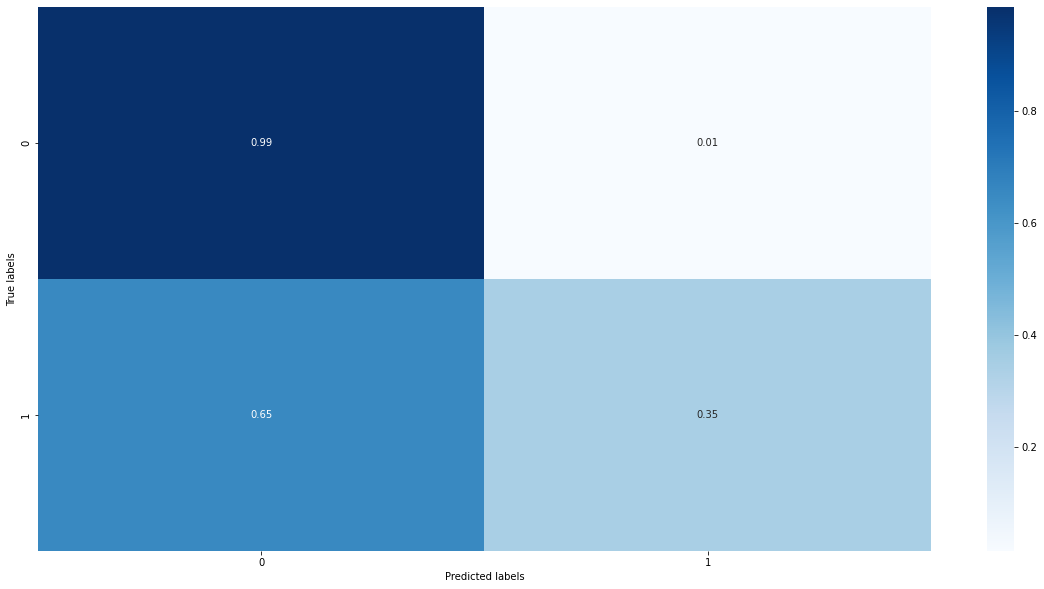

In [ ]:
base_preds = classifier.fit(X_train, y_train).predict(X_val)
labels = df2['rating_class'].unique()
cm = confusion_matrix(y_val, base_preds, labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [ ]:
#Quick diagnostics
print(classification_report(y_val.astype(str), base_preds.astype(str)))

              precision    recall  f1-score   support

           0       0.64      0.51      0.57       269
           1       0.34      0.17      0.23       230
           2       0.88      0.96      0.92      2001

    accuracy                           0.84      2500
   macro avg       0.62      0.55      0.57      2500
weighted avg       0.81      0.84      0.82      2500



## Logistic Regression

In [ ]:
classifier = LogisticRegression(random_state=0, class_weight='balanced')

In [ ]:
alpha_list = np.linspace(0.1,1,10)
alpha_list = np.around(alpha_list, decimals=4)
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
params = {'C': alpha_list}

In [ ]:
import time
start_time = time.time()
grid_no_up = GridSearchCV(classifier, param_grid=params, cv=kf, n_jobs=-1, verbose=1, scoring='f1_macro').fit(X_train, y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

In [ ]:
base_preds = classifier.fit(X_train, y_train).predict(X_val)
labels = df2['overall_rating'].unique()
cm = confusion_matrix(y_val, base_preds, labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

ValueError: ignored

In [ ]:
#Quick diagnostics
print(classification_report(y_val.astype(str), base_preds.astype(str)))

              precision    recall  f1-score   support

           0       0.53      0.68      0.59       269
           1       0.96      0.93      0.94      2231

    accuracy                           0.90      2500
   macro avg       0.74      0.80      0.77      2500
weighted avg       0.91      0.90      0.91      2500



## Deep Learning

In [ ]:
# Word2vec
import gensim

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

In [ ]:
documents = [_text.split() for _text in df_train.review_text]

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, window=7, min_count=32, workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1915


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=32)

(10831744, 14318176)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.review_text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 26233


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.review_text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.review_text), maxlen=300)

In [ ]:
labels = df_train.rating_class.unique().tolist()
labels.append("NEUTRAL")

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.rating_class.tolist())

y_train = encoder.transform(df_train.rating_class.tolist())
y_test = encoder.transform(df_test.rating_class.tolist())

y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(26233, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          7869900   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 8,089,677
Trainable params: 219,777
Non-trainable params: 7,869,900
_________________________________________________________________


In [ ]:
from tensorflow.keras.metrics import AUC
pr_metric = AUC(curve='PR', num_thresholds=1000) # The higher the threshold value, the more accurate it is calculated.

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=Adam(5e-4), metrics=[pr_metric])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), np.ravel(y_train))

In [ ]:
class_weight = {i : class_weight[i] for i in range(2)}

In [ ]:
H = model.fit(x_train, y_train, batch_size=1024, epochs=10, class_weight=class_weight, validation_split=0.05, verbose=1, callbacks=callbacks)

Epoch 1/10
7/7 [==============================] - 109s 15s/step - loss: 0.6782 - auc: 0.9187 - val_loss: 0.6767 - val_auc: 0.9317 - lr: 5.0000e-04
Epoch 2/10
7/7 [==============================] - 101s 14s/step - loss: 0.6329 - auc: 0.9484 - val_loss: 0.6453 - val_auc: 0.9384 - lr: 5.0000e-04
Epoch 3/10
7/7 [==============================] - 100s 14s/step - loss: 0.5954 - auc: 0.9582 - val_loss: 0.6181 - val_auc: 0.9446 - lr: 5.0000e-04
Epoch 4/10
7/7 [==============================] - 101s 14s/step - loss: 0.5635 - auc: 0.9646 - val_loss: 0.5744 - val_auc: 0.9499 - lr: 5.0000e-04
Epoch 5/10
7/7 [==============================] - 100s 14s/step - loss: 0.5342 - auc: 0.9686 - val_loss: 0.4987 - val_auc: 0.9562 - lr: 5.0000e-04
Epoch 6/10
7/7 [==============================] - 100s 14s/step - loss: 0.5203 - auc: 0.9713 - val_loss: 0.5847 - val_auc: 0.9616 - lr: 5.0000e-04
Epoch 7/10
7/7 [==============================] - 100s 14s/step - loss: 0.5196 - auc: 0.9723 - val_loss: 0.4981 - val_

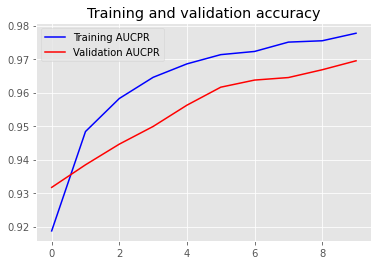

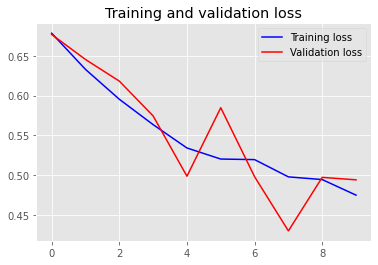

In [ ]:
acc = H.history['auc']
val_acc = H.history['val_auc']
loss = H.history['loss']
val_loss = H.history['val_loss']
 
epochs = range(len(acc))

plt.style.use("ggplot")
 
plt.plot(epochs, acc, 'b', label='Training AUCPR')
plt.plot(epochs, val_acc, 'r', label='Validation AUCPR')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=5000)
print()
print("Area Under Precision-Recall Curve:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 8s 8s/step - loss: 0.4981 - auc: 0.9730

Area Under Precision-Recall Curve: 0.9729722142219543
LOSS: 0.49807021021842957
CPU times: user 13.7 s, sys: 1.03 s, total: 14.8 s
Wall time: 10.3 s


In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return " ".join(tokens)

In [ ]:
def decode_sentiment(score, include_neutral):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= 0.4:
            label = 'NEGATIVE'
        elif score >= 0.7:
            label = 'POSITIVE'
        return label
    else:
        return 0 if score < 0.5 else 1  

In [ ]:
def predict(model, tokenizer, text, include_neutral=False, sequence_length=300):
    """
    model: Keras model
    tokenizer: Tokenizer object
    tweets: List of strings (tweets)
    """
    
    start_at = time.time()
    # Tokenize text
    text = [preprocess(t) for t in text]
    X = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=sequence_length)
    # Predict
    score = model.predict(X, batch_size=50)
    # Decode sentiment
    labels = []
    for s in score:
        label = decode_sentiment(s, include_neutral=include_neutral)
        labels.append(label)

    return {"label": labels, "score": score,
       "elapsed_time": time.time()-start_at}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.rating_class)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 8s 8s/step
CPU times: user 13.9 s, sys: 491 ms, total: 14.4 s
Wall time: 10.6 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
import itertools

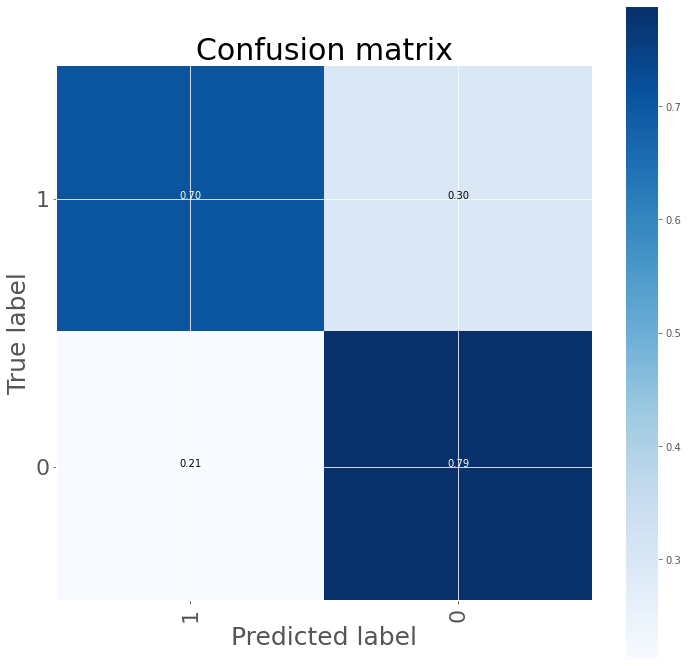

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.rating_class.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.30      0.70      0.42       281
           1       0.95      0.79      0.86      2219

    accuracy                           0.78      2500
   macro avg       0.63      0.75      0.64      2500
weighted avg       0.88      0.78      0.81      2500



# Save model

In [ ]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://ce57f8f8-ffef-41b0-8960-6a032d14db7d/assets


In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets
